# Preprocessing

In [106]:
#Import dependencies.

import pandas as pd
import time
import numpy as np
import calendar
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [107]:
t1 = time.time()
df = pd.read_csv('Motor_Vehicle_Collisions_Crashes.csv')
df['TIME'] = df['CRASH DATE'] + ' ' + df['CRASH TIME']
df['TIME'] = pd.to_datetime(df['TIME'], format="%m/%d/%Y %H:%M")
t2 = time.time()

#Discard observations where LOCATION is missing.
df = df.loc[~df['LOCATION'].isna()]
df = df.loc[~(df['LOCATION'] == '(0.0, 0.0)')]

df['ZIP CODE'] = df['ZIP CODE'].replace({'     ' : np.nan})
#df['ZIP CODE'] = df['ZIP CODE'].astype(float).fillna(0).astype(int)

#Discard 2012 and 2021. 
df = df.loc[(df['TIME'].dt.year > 2012) & (df['TIME'].dt.year < 2021)]
print(f'Time elapsed: {t2-t1} seconds.')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time elapsed: 13.154727935791016 seconds.


## Adding new columns

We wish to add a column specifying whether or not any was injured or killed.



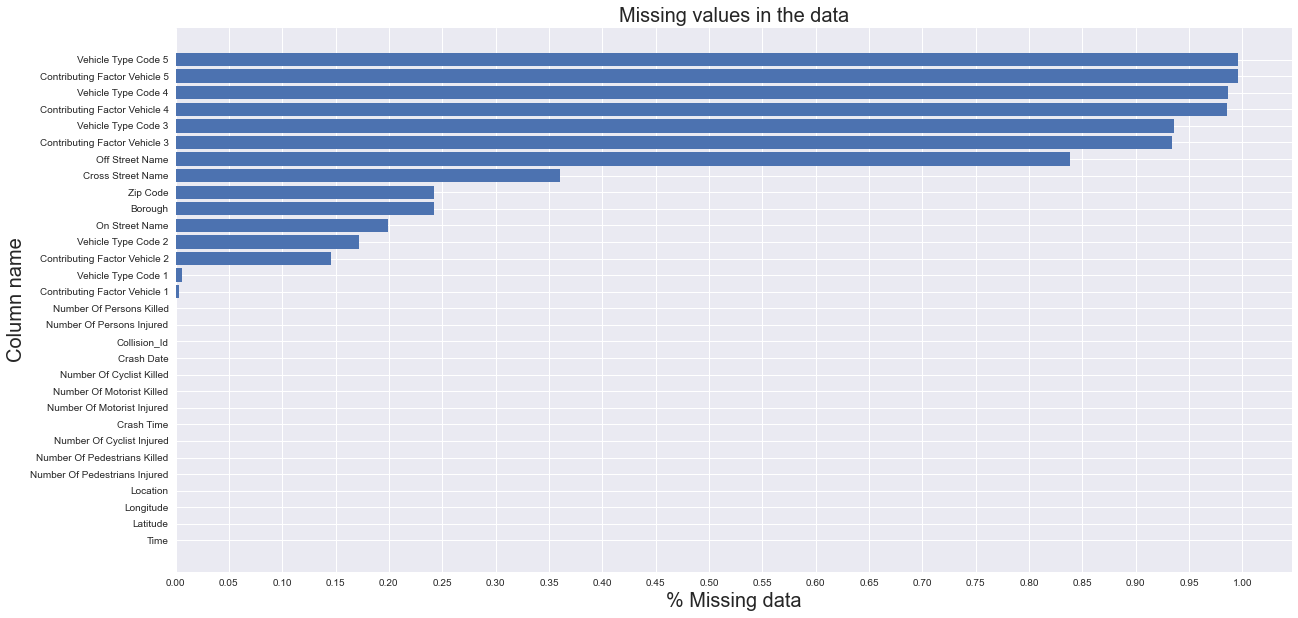

In [227]:
plt.figure(figsize=(20,10))
plt.title('Missing values in the data', fontsize=20)
missing_pct_df = pd.DataFrame((df.isnull().sum(axis=0)/len(df)).sort_values(ascending=False)).reset_index(); missing_pct_df.columns = ['Column', 'MissingPct']
plt.barh([x.title() for x in missing_pct_df['Column']], missing_pct_df['MissingPct'])
plt.gca().invert_yaxis()
plt.xlabel('% Missing data', fontsize=20)
plt.ylabel('Column name', fontsize=20)
plt.xticks(np.arange(0, 1.05, 0.05))
plt.show()

## Filling out ZIP Code and Borough

In [239]:
zip_and_borough = df.loc[~np.any(pd.isna(df[['ZIP CODE', 'BOROUGH']]),axis=1)][['LATITUDE', 'LONGITUDE', 'ZIP CODE', 'BOROUGH']]
zip_and_borough['ZIP CODE'] = zip_and_borough['ZIP CODE'].astype(int)
zip_and_borough_counts = pd.DataFrame(zip_and_borough.drop(['LATITUDE', 'LONGITUDE'],axis=1).groupby(['ZIP CODE', 'BOROUGH']).size()).reset_index(); zip_and_borough_counts.columns = ['ZIP CODE', 'BOROUGH', 'COUNTS']

In [240]:
print(zip_and_borough['ZIP CODE'].unique().shape)
zip_and_borough.head()

(231,)


,LATITUDE,LONGITUDE,ZIP CODE,BOROUGH
199,40.824066,-73.908714,10456,BRONX
218,40.747650,-73.863010,11368,QUEENS
221,40.713920,-73.991714,10002,MANHATTAN
224,40.820990,-73.895890,10459,BRONX
236,40.599728,-73.937920,11229,BROOKLYN


In [241]:
print('Troublesome ZIP codes:')
for zip_, df_ in zip_and_borough_counts.groupby('ZIP CODE'):
    if len(df_) != 1:
        print(zip_)
print('')
zip_and_borough_counts.loc[zip_and_borough_counts['ZIP CODE'].apply(lambda x : x in [11208, 11237, 11385, 11421])]

Troublesome ZIP codes:
11208
11237
11385
11421



,ZIP CODE,BOROUGH,COUNTS
142,11208,BROOKLYN,12337
143,11208,QUEENS,156
171,11237,BROOKLYN,6367
172,11237,QUEENS,280
203,11385,BROOKLYN,30
204,11385,QUEENS,13513
215,11421,BROOKLYN,6
216,11421,QUEENS,4208


In [235]:
zip_to_borough = {}
for zip_, df_ in zip_and_borough_counts.groupby('ZIP CODE'): zip_to_borough[zip_] = df_['BOROUGH'].iloc[df_['COUNTS'].argmax()]

In [242]:
plt.plot(zip_and_borough['LATITUDE', 'LONGITUDE'])

,LATITUDE,LONGITUDE,ZIP CODE,BOROUGH
199,40.824066,-73.908714,10456,BRONX
218,40.747650,-73.863010,11368,QUEENS
221,40.713920,-73.991714,10002,MANHATTAN
224,40.820990,-73.895890,10459,BRONX
236,40.599728,-73.937920,11229,BROOKLYN
...,...,...,...,...
1681220,40.784553,-73.855010,11356,QUEENS
1681338,40.728176,-73.984857,10009,MANHATTAN
1681396,40.612692,-73.982658,11204,BROOKLYN
1681522,40.693211,-73.912556,11221,BROOKLYN
